In [1]:
import pandas as pd
import glob
path = "D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024"

file_list = glob.glob(path + "/*.csv")
print('File names:', file_list)

# pd.concat(map(pd.read_csv, file_list), 
#           ignore_index=True).to_csv('D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024.csv',index=False)

File names: ['D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024\\viirs-jpss1_2021_Indonesia.csv', 'D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024\\viirs-jpss1_2022_Indonesia.csv', 'D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024\\viirs-jpss1_2023_Indonesia.csv', 'D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024\\viirs-jpss1_2024_Indonesia.csv']


In [2]:
import pandas as pd

# Bounding boxes
SUMATRA_BBOX = {"lat_min": -6.0, "lat_max": 6.0, "lon_min": 94.0, "lon_max": 106.0}
KALIMANTAN_BBOX = {"lat_min": -4.5, "lat_max": 7.5, "lon_min": 108.0, "lon_max": 119.5}

def filter_sumatra_kalimantan(df):
    """Keep only hotspots in Sumatra or Kalimantan."""
    s_mask = (
        (df["latitude"] >= SUMATRA_BBOX["lat_min"]) & (df["latitude"] <= SUMATRA_BBOX["lat_max"]) &
        (df["longitude"] >= SUMATRA_BBOX["lon_min"]) & (df["longitude"] <= SUMATRA_BBOX["lon_max"])
    )
    k_mask = (
        (df["latitude"] >= KALIMANTAN_BBOX["lat_min"]) & (df["latitude"] <= KALIMANTAN_BBOX["lat_max"]) &
        (df["longitude"] >= KALIMANTAN_BBOX["lon_min"]) & (df["longitude"] <= KALIMANTAN_BBOX["lon_max"])
    )
    df = df.loc[s_mask | k_mask].copy()
    df["region"] = df.apply(lambda row: "Sumatra" if s_mask.loc[row.name] else "Kalimantan", axis=1)
    return df

# sort by confidence (h > n > l), then by frp (high to low), then by bright_ti4 (high to low)
dfs = []
for i in range(2021, 2025):  # 2021–2024
    file_path = f"D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/Hotspot_Indonesia_2021-2024-20250831T121136Z-1-001/Hotspot_Indonesia_2021-2024/viirs-jpss1_{i}_Indonesia.csv"
    df = pd.read_csv(file_path)

    df["year"] = i   # add year column

    # 🔹 Filter to Sumatra + Kalimantan
    df = filter_sumatra_kalimantan(df)

    dfs.append(df)

    print(f"\n=== Year {i} (Filtered) ===")
    print(df.head())

    confidence_map = {"l": 1, "n": 2, "h": 3}
    df["confidence_score"] = df["confidence"].map(confidence_map).fillna(0)

    df_sorted = df.sort_values(
        by=["confidence_score", "frp", "bright_ti4"],
        ascending=[False, False, False]
    )

    print("\nTop 5 Hotspots (Sumatra+Kalimantan):")
    print(df_sorted.head(5)[["latitude", "longitude", "bright_ti4", "frp", "confidence", "daynight", "region"]])

    output_path = f"ranked_hotspots_{i}_SumKal.csv"
    df_sorted.to_csv(output_path, index=False)
    print(f"Ranked hotspots saved to {output_path}")

# Merge all years
all_data = pd.concat(dfs, ignore_index=True)



=== Year 2021 (Filtered) ===
    latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
10   3.29463   97.94682      325.14  0.46   0.39  2021-01-01       638   
23  -0.96207  117.14684      302.49  0.39   0.36  2021-01-01      1737   
24  -0.96537  117.14632      296.20  0.39   0.36  2021-01-01      1737   
40   1.06977  100.11356      302.74  0.33   0.55  2021-01-01      1917   
48  -2.89252  101.54279      328.77  0.44   0.46  2021-01-02       617   

   satellite instrument confidence  version  bright_ti5   frp daynight  type  \
10       N20      VIIRS          l        2      296.89  2.35        D     0   
23       N20      VIIRS          n        2      257.19  2.03        N     2   
24       N20      VIIRS          n        2      253.54  1.92        N     0   
40       N20      VIIRS          n        2      283.12  0.90        N     0   
48       N20      VIIRS          n        2      293.51  3.97        D     0   

    year      region  
10  2021     Sumatra 

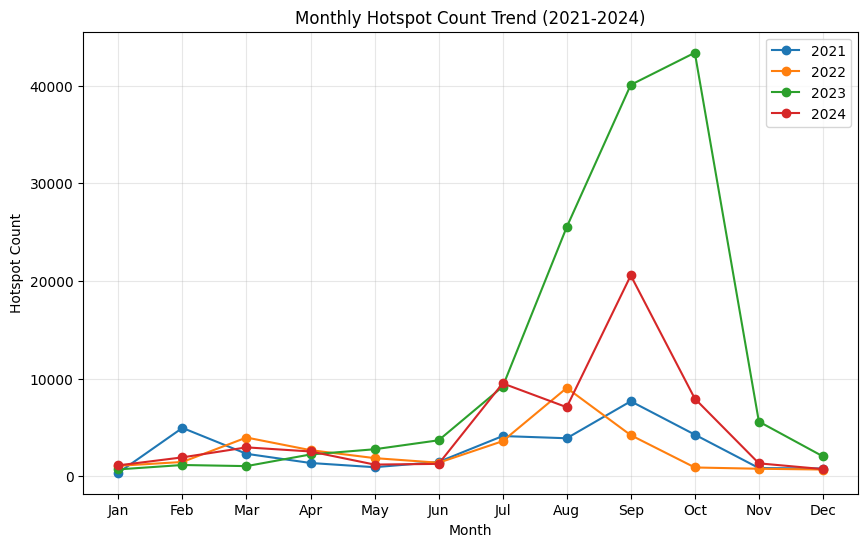

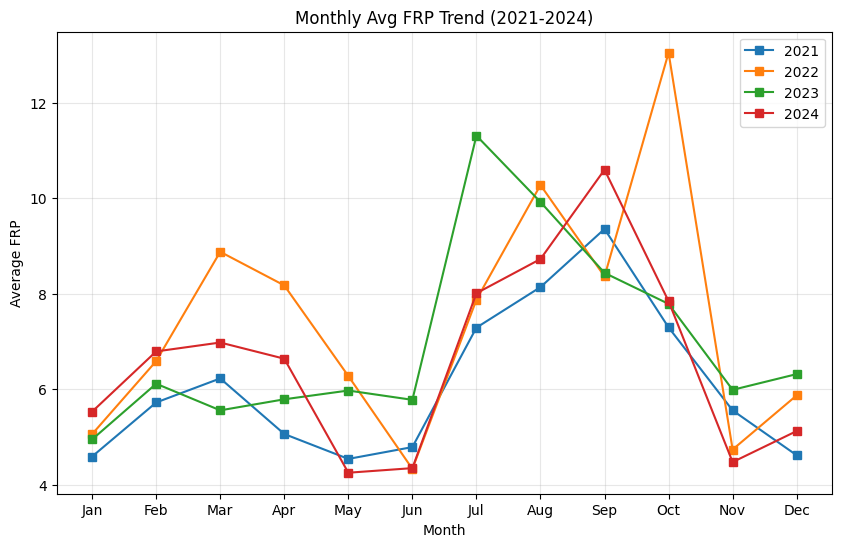

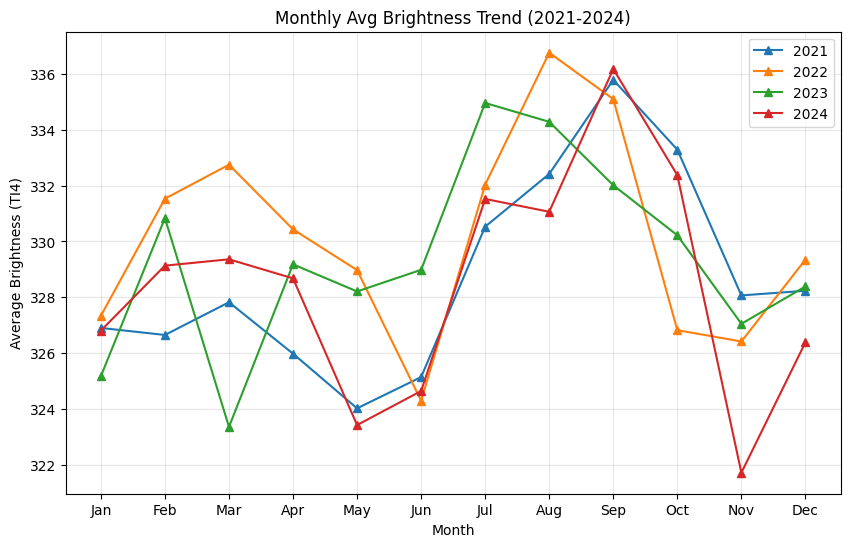

   year  hotspot_count   avg_frp  max_frp  avg_bright
0  2021          33018  7.141624   415.51  330.791309
1  2022          31688  8.399991   983.60  332.698510
2  2023         137423  8.345541   564.86  331.495664
3  2024          58229  8.513949   550.26  332.216895


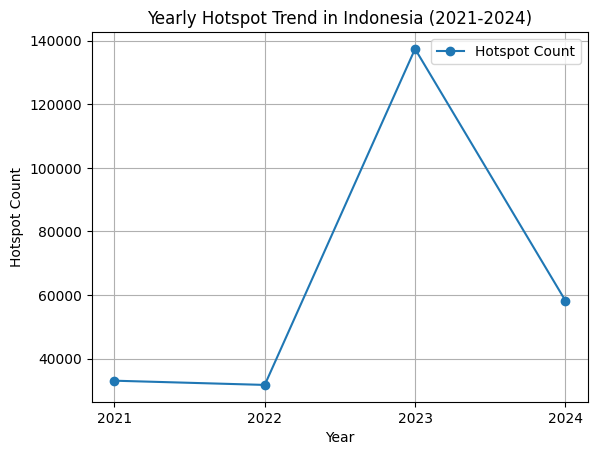

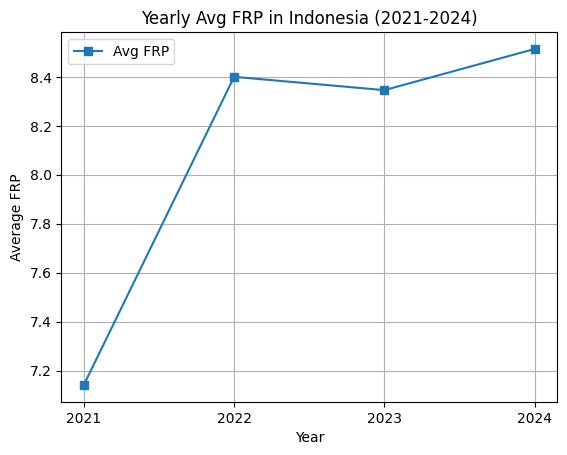

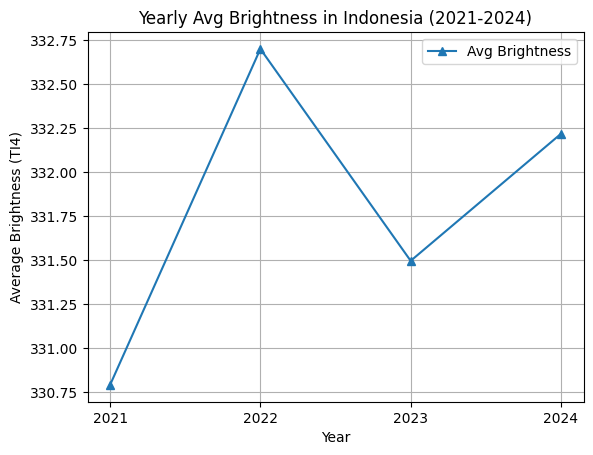

In [3]:
import matplotlib.pyplot as plt

# --- Prepare datetime columns ---
all_data["acq_date"] = pd.to_datetime(all_data["acq_date"])
all_data["month"] = all_data["acq_date"].dt.month
all_data["year"] = all_data["acq_date"].dt.year

# --- Monthly aggregation ---
monthly_trend = all_data.groupby(["year", "month"]).agg(
    hotspot_count=("latitude", "count"),
    avg_frp=("frp", "mean"),
    max_frp=("frp", "max"),
    avg_bright=("bright_ti4", "mean")
).reset_index()

# --- Plot monthly Hotspot Count ---
plt.figure(figsize=(10,6))
for y in monthly_trend["year"].unique():
    subset = monthly_trend[monthly_trend["year"] == y]
    plt.plot(subset["month"], subset["hotspot_count"], marker="o", label=str(y))

plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.xlabel("Month")
plt.ylabel("Hotspot Count")
plt.title("Monthly Hotspot Count Trend (2021-2024)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot monthly Avg FRP ---
plt.figure(figsize=(10,6))
for y in monthly_trend["year"].unique():
    subset = monthly_trend[monthly_trend["year"] == y]
    plt.plot(subset["month"], subset["avg_frp"], marker="s", label=str(y))

plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.xlabel("Month")
plt.ylabel("Average FRP")
plt.title("Monthly Avg FRP Trend (2021-2024)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot monthly Avg Brightness ---
plt.figure(figsize=(10,6))
for y in monthly_trend["year"].unique():
    subset = monthly_trend[monthly_trend["year"] == y]
    plt.plot(subset["month"], subset["avg_bright"], marker="^", label=str(y))

plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.xlabel("Month")
plt.ylabel("Average Brightness (TI4)")
plt.title("Monthly Avg Brightness Trend (2021-2024)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Yearly aggregation ---
trend = all_data.groupby("year").agg(
    hotspot_count=("latitude", "count"),
    avg_frp=("frp", "mean"),
    max_frp=("frp", "max"),
    avg_bright=("bright_ti4", "mean")
).reset_index()

print(trend)

# --- Yearly Hotspot Count ---
plt.plot(trend["year"], trend["hotspot_count"], marker="o", label="Hotspot Count")
plt.xticks(trend["year"])
plt.xlabel("Year")
plt.ylabel("Hotspot Count")
plt.title("Yearly Hotspot Trend in Indonesia (2021-2024)")
plt.legend()
plt.grid(True)
plt.show()

# --- Yearly Avg FRP ---
plt.plot(trend["year"], trend["avg_frp"], marker="s", label="Avg FRP")
plt.xticks(trend["year"])
plt.xlabel("Year")
plt.ylabel("Average FRP")
plt.title("Yearly Avg FRP in Indonesia (2021-2024)")
plt.legend()
plt.grid(True)
plt.show()

# --- Yearly Avg Brightness ---
plt.plot(trend["year"], trend["avg_bright"], marker="^", label="Avg Brightness")
plt.xticks(trend["year"])
plt.xlabel("Year")
plt.ylabel("Average Brightness (TI4)")
plt.title("Yearly Avg Brightness in Indonesia (2021-2024)")
plt.legend()
plt.grid(True)
plt.show()


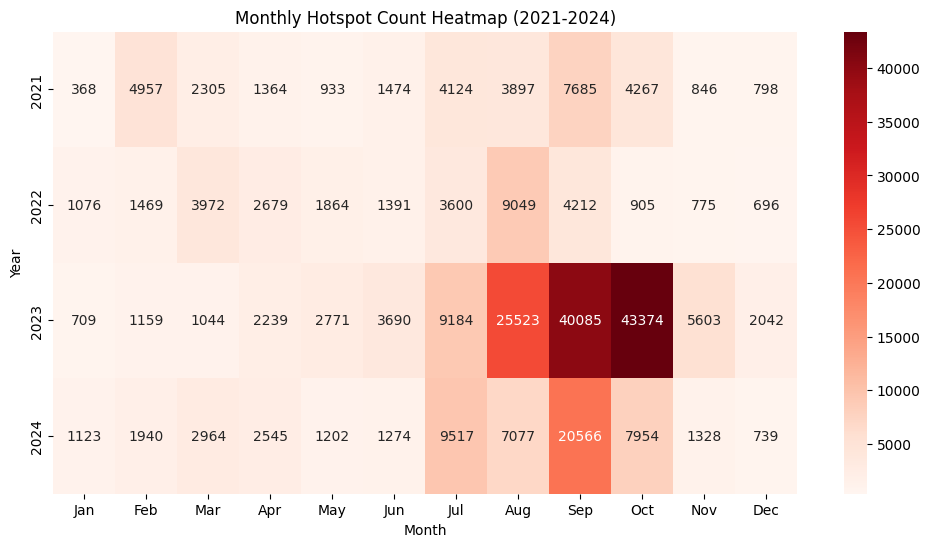

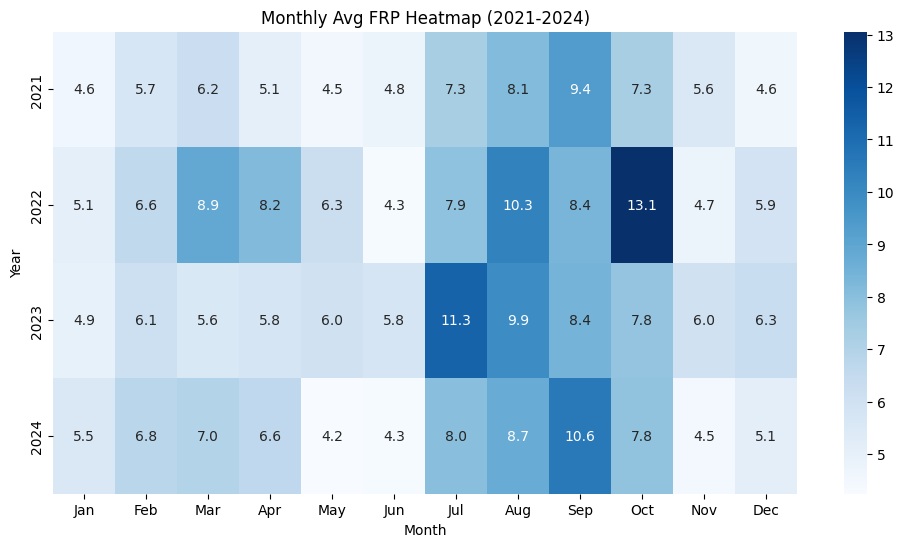

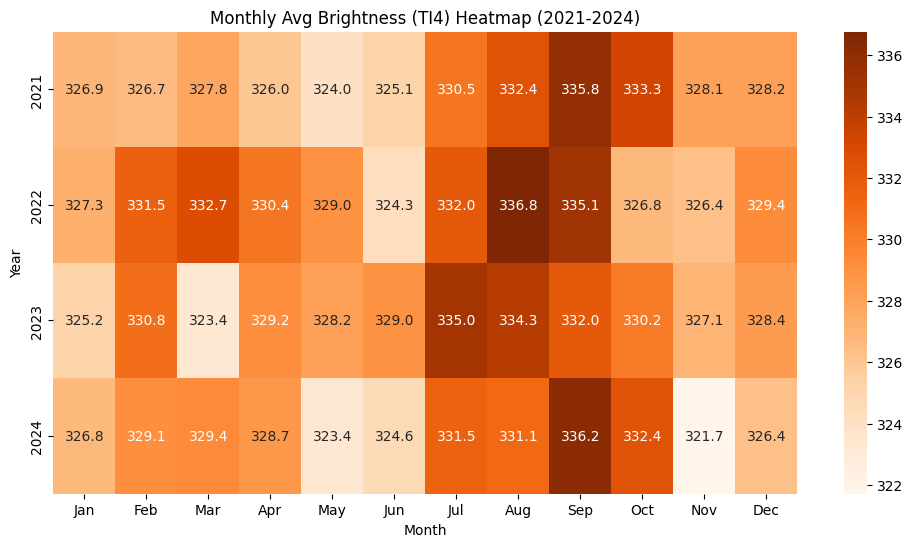

In [4]:
import seaborn as sns

# --- Hotspot Count Heatmap ---
heatmap_data_count = monthly_trend.pivot(index="year", columns="month", values="hotspot_count")

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data_count, cmap="Reds", annot=True, fmt="d")
plt.title("Monthly Hotspot Count Heatmap (2021-2024)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(
    [i+0.5 for i in range(12)], 
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    rotation=0
)
plt.show()

# --- Avg FRP Heatmap ---
heatmap_data_frp = monthly_trend.pivot(index="year", columns="month", values="avg_frp")

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data_frp, cmap="Blues", annot=True, fmt=".1f")
plt.title("Monthly Avg FRP Heatmap (2021-2024)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(
    [i+0.5 for i in range(12)], 
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    rotation=0
)
plt.show()

# --- Avg Brightness Heatmap ---
heatmap_data_bright = monthly_trend.pivot(index="year", columns="month", values="avg_bright")

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data_bright, cmap="Oranges", annot=True, fmt=".1f")
plt.title("Monthly Avg Brightness (TI4) Heatmap (2021-2024)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(
    [i+0.5 for i in range(12)], 
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    rotation=0
)
plt.show()


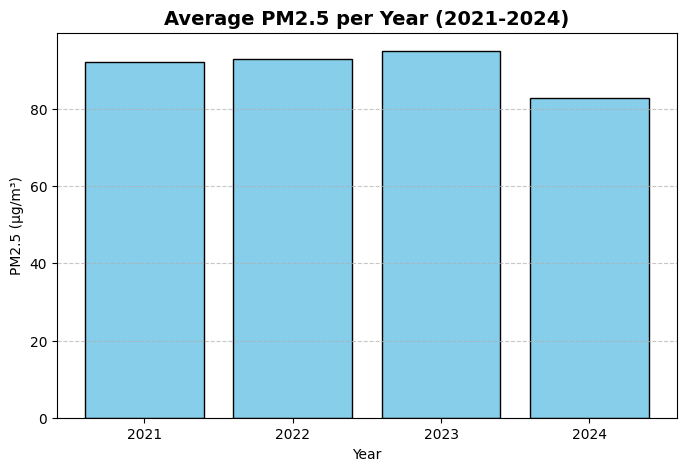

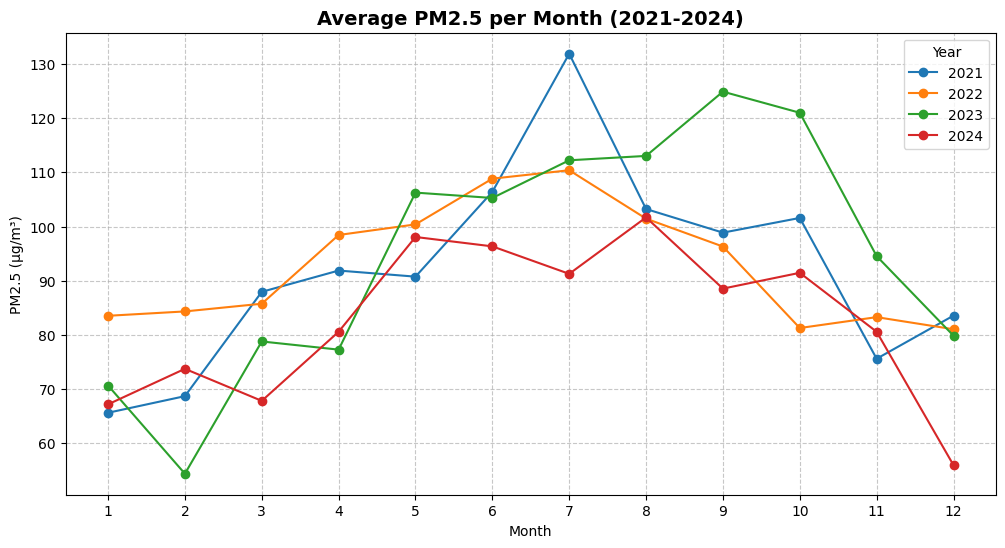

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV (adjust path if needed)
df = pd.read_csv("D:/Downloads/VisualQuest2025_CSV-Warriors/dataset/PM25_Consentration_In_Jakarta-20250831T121137Z-1-001/PM25_Consentration_In_Jakarta/ispu_dki_all.csv")

# Convert 'tanggal' to datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')

# Filter rows for 2021–2024
df = df[(df['tanggal'].dt.year >= 2021) & (df['tanggal'].dt.year <= 2024)]

# Extract year and month
df['year'] = df['tanggal'].dt.year
df['month'] = df['tanggal'].dt.month

# Convert pm25 to numeric
df['pm25'] = pd.to_numeric(df['pm25'], errors='coerce')

# Group by year and month
monthly_avg = df.groupby(['year', 'month'])['pm25'].mean().reset_index()

# Yearly average
yearly_avg = df.groupby('year')['pm25'].mean().reset_index()

# --- Visualization ---

# 1. Yearly average bar chart
plt.figure(figsize=(8,5))
plt.bar(yearly_avg['year'], yearly_avg['pm25'], color="skyblue", edgecolor="black")
plt.title("Average PM2.5 per Year (2021-2024)", fontsize=14, weight="bold")
plt.xticks(yearly_avg['year'])
plt.xlabel("Year")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Monthly average line chart
plt.figure(figsize=(12,6))
for year in monthly_avg['year'].unique():
    subset = monthly_avg[monthly_avg['year'] == year]
    plt.plot(subset['month'], subset['pm25'], marker='o', label=str(year))

plt.title("Average PM2.5 per Month (2021-2024)", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(range(1,13))
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


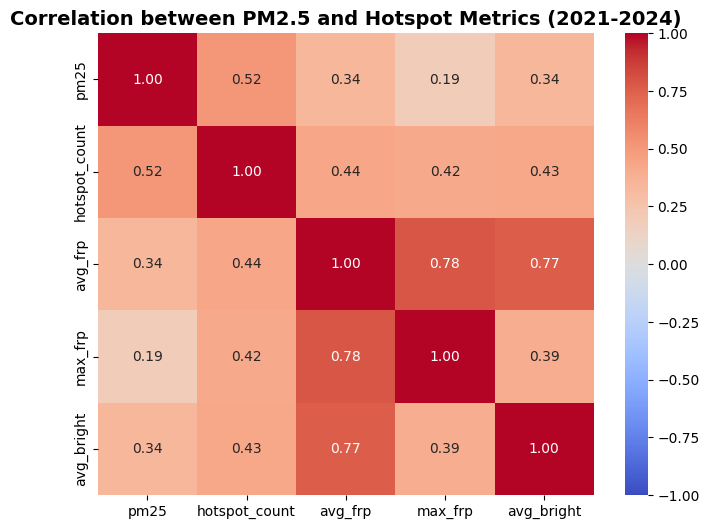

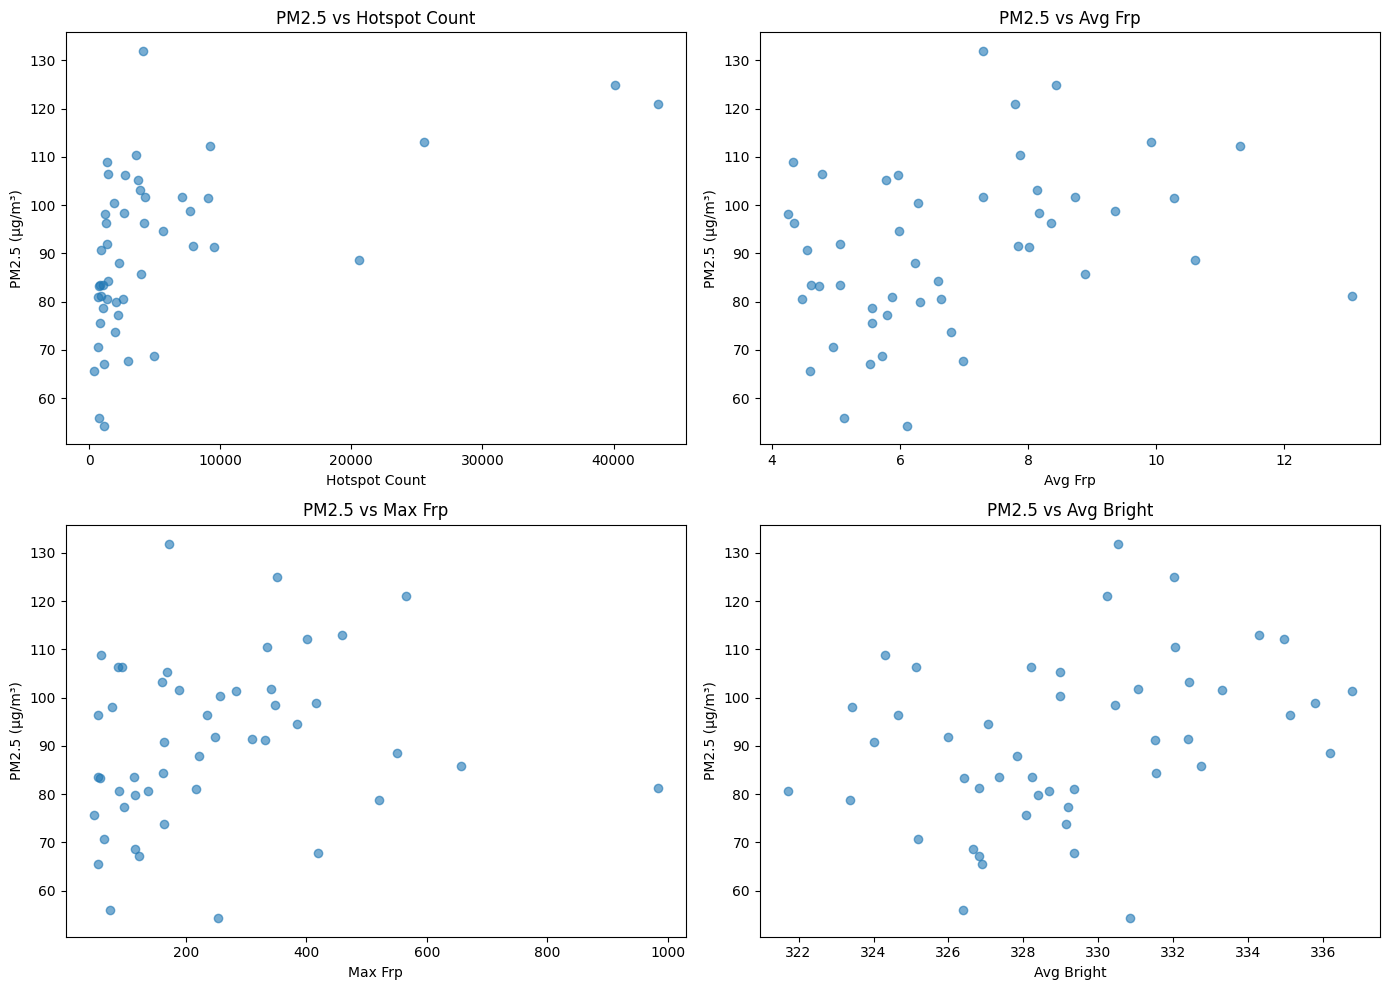

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# combining pm_analysis and hostspot data for correlation analysis
# --- Merge datasets on year & month ---
merged = pd.merge(monthly_trend, monthly_avg, on=["year","month"], how="inner")

# --- Correlation matrix ---
corr = merged[["pm25", "hotspot_count", "avg_frp", "max_frp", "avg_bright"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between PM2.5 and Hotspot Metrics (2021-2024)", fontsize=14, weight="bold")
plt.show()

# --- Scatter plots for visual correlation ---
metrics = ["hotspot_count", "avg_frp", "max_frp", "avg_bright"]

plt.figure(figsize=(14,10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2,2,i)
    plt.scatter(merged[metric], merged["pm25"], alpha=0.6)
    plt.xlabel(metric.replace("_"," ").title())
    plt.ylabel("PM2.5 (µg/m³)")
    plt.title(f"PM2.5 vs {metric.replace('_',' ').title()}")

plt.tight_layout()
plt.show()


In [7]:
import folium
import pandas as pd
import branca.colormap as cm

# --- Step 1: Prepare hotspot grid ---
grid = (
    all_data.groupby([
        all_data["latitude"].round(1), 
        all_data["longitude"].round(1)
    ])
    .size()
    .reset_index(name="count")
)

# --- Step 2: Hotspot color scale ---
colormap = cm.linear.YlOrRd_09.scale(grid["count"].min(), grid["count"].max())

# --- Step 3: Create map centered on Indonesia ---
m = folium.Map(location=[-2, 118], zoom_start=5)

# --- Step 4: Add hotspots as circles ---
for _, row in grid.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=min(row["count"]**0.5, 15),  
        color=colormap(row["count"]),
        fill=True,
        fill_opacity=0.7,
        popup=f"Hotspot Count: {row['count']}"
    ).add_to(m)

# --- Step 5: Add Jakarta marker with PM2.5 info ---
jakarta_lat, jakarta_lon = -6.2, 106.8
jakarta_pm25 = df.groupby("year")["pm25"].mean().round(1).to_dict()  # yearly avg PM2.5

jakarta_popup = "<b>Jakarta PM2.5 yearly average (µg/m³)</b><br>"
for year, val in jakarta_pm25.items():
    jakarta_popup += f"{year}: {val}<br>"

folium.Marker(
    location=[jakarta_lat, jakarta_lon],
    popup=folium.Popup(jakarta_popup, max_width=250),
    icon=folium.Icon(color="blue", icon="cloud")
).add_to(m)

# --- Step 6: Add color legend ---
colormap.caption = "Hotspot Count (rounded lat/lon grid)"
colormap.add_to(m)

# --- Save map ---
m.save("hotspot_pm25_map.html")


C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\938185742.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mon

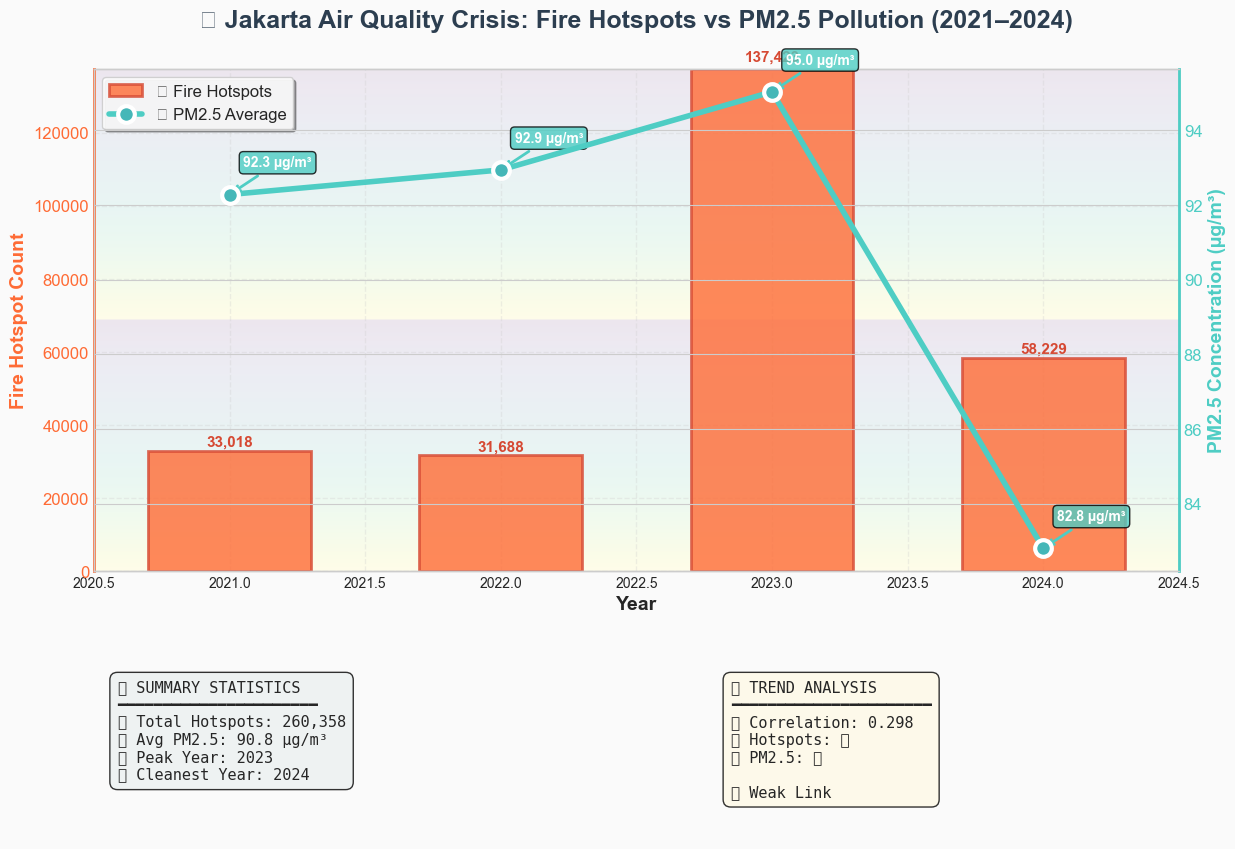

C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\938185742.py:180: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\938185742.py:180: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\938185742.py:180: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


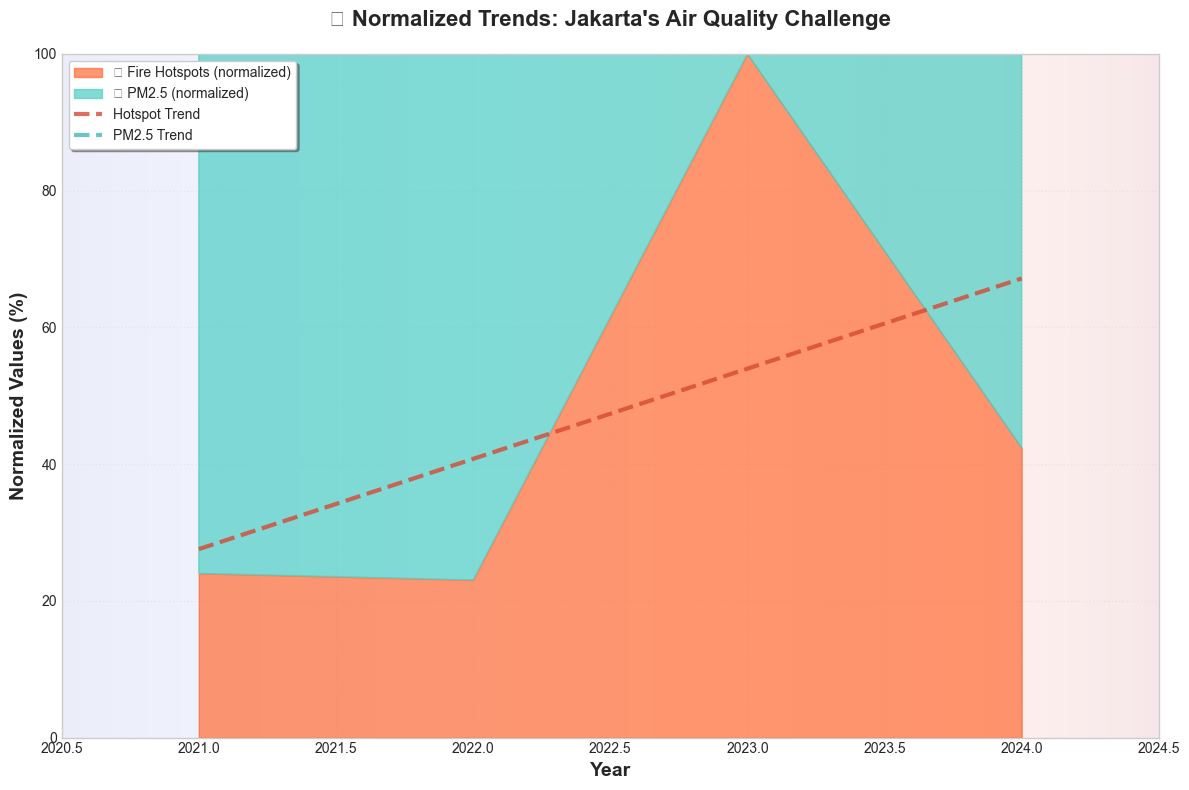

✨ Beautiful charts created! Your data now tells a compelling visual story! ✨


In [8]:
# Beautiful Yearly Comparison: Hotspots vs PM2.5

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# --- Yearly Aggregation ---
hotspot_yearly = all_data.groupby("year")["latitude"].count().reset_index(name="hotspot_count")
pm25_yearly = df.groupby("year")["pm25"].mean().reset_index(name="pm25_avg")

# Merge
yearly_data = pd.merge(hotspot_yearly, pm25_yearly, on="year")

# Create figure with custom styling
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# --- Main Chart: Dual Axis with Enhanced Styling ---
ax1 = fig.add_subplot(gs[0, :])

# Create gradient background
gradient = np.linspace(0, 1, 256).reshape(256, -1)
gradient = np.vstack((gradient, gradient))
extent = [yearly_data["year"].min()-0.5, yearly_data["year"].max()+0.5, 0, yearly_data["hotspot_count"].max()]
ax1.imshow(gradient, aspect='auto', extent=extent, alpha=0.1, cmap='viridis')

# Hotspot bars with gradient effect
bars = ax1.bar(yearly_data["year"], yearly_data["hotspot_count"], 
               width=0.6, color='#FF6B35', alpha=0.8, 
               edgecolor='#D64933', linewidth=2,
               label="🔥 Fire Hotspots")

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11, color='#D64933')

ax1.set_ylabel("Fire Hotspot Count", color='#FF6B35', fontsize=14, fontweight='bold')
ax1.tick_params(axis="y", labelcolor='#FF6B35', labelsize=12)
ax1.spines['left'].set_color('#FF6B35')
ax1.spines['left'].set_linewidth(2)

# PM2.5 line with markers
ax2 = ax1.twinx()
line = ax2.plot(yearly_data["year"], yearly_data["pm25_avg"], 
                color='#4ECDC4', marker='o', linewidth=4, 
                markersize=12, markerfacecolor='#45B7B8', 
                markeredgecolor='white', markeredgewidth=3,
                label="💨 PM2.5 Average", zorder=10)

# Add value labels for PM2.5
for i, (year, pm25) in enumerate(zip(yearly_data["year"], yearly_data["pm25_avg"])):
    ax2.annotate(f'{pm25:.1f} µg/m³', 
                xy=(year, pm25), 
                xytext=(10, 20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#4ECDC4', alpha=0.8),
                fontsize=10, fontweight='bold', color='white',
                arrowprops=dict(arrowstyle='->', color='#4ECDC4', lw=2))

ax2.set_ylabel("PM2.5 Concentration (µg/m³)", color='#4ECDC4', fontsize=14, fontweight='bold')
ax2.tick_params(axis="y", labelcolor='#4ECDC4', labelsize=12)
ax2.spines['right'].set_color('#4ECDC4')
ax2.spines['right'].set_linewidth(2)

# Customize main chart
ax1.set_xlabel("Year", fontsize=14, fontweight='bold')
ax1.set_title("🌍 Jakarta Air Quality Crisis: Fire Hotspots vs PM2.5 Pollution (2021–2024)", 
              fontsize=18, fontweight='bold', pad=30, color='#2C3E50')

# Add grid with custom styling
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax1.set_axisbelow(True)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='upper left', frameon=True, fancybox=True,
    shadow=True, fontsize=12
)

# Now set frame properties safely
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.9)


# --- Summary Statistics Subplot ---
ax3 = fig.add_subplot(gs[1, 0])
total_hotspots = yearly_data["hotspot_count"].sum()
avg_pm25 = yearly_data["pm25_avg"].mean()

# Create info boxes
info_text = f"""📊 SUMMARY STATISTICS
━━━━━━━━━━━━━━━━━━━━━━
🔥 Total Hotspots: {total_hotspots:,}
💨 Avg PM2.5: {avg_pm25:.1f} µg/m³
📈 Peak Year: {yearly_data.loc[yearly_data["hotspot_count"].idxmax(), "year"]}
📉 Cleanest Year: {yearly_data.loc[yearly_data["pm25_avg"].idxmin(), "year"]}"""

ax3.text(0.05, 0.95, info_text, transform=ax3.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='#ECF0F1', alpha=0.8))
ax3.axis('off')

# --- Trend Analysis Subplot ---
ax4 = fig.add_subplot(gs[1, 1])

# Calculate correlations and trends
correlation = yearly_data[["hotspot_count", "pm25_avg"]].corr().iloc[0,1]
hotspot_trend = "📈" if yearly_data["hotspot_count"].iloc[-1] > yearly_data["hotspot_count"].iloc[0] else "📉"
pm25_trend = "📈" if yearly_data["pm25_avg"].iloc[-1] > yearly_data["pm25_avg"].iloc[0] else "📉"

trend_text = f"""📊 TREND ANALYSIS
━━━━━━━━━━━━━━━━━━━━━━
📊 Correlation: {correlation:.3f}
🔥 Hotspots: {hotspot_trend}
💨 PM2.5: {pm25_trend}

{"⚠️ Strong Positive Link!" if correlation > 0.7 else 
 "✅ Moderate Link" if correlation > 0.3 else 
 "❓ Weak Link"}"""

ax4.text(0.05, 0.95, trend_text, transform=ax4.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='#FEF9E7', alpha=0.8))
ax4.axis('off')

# Final styling touches
fig.patch.set_facecolor('#FAFAFA')
plt.suptitle('')  # Remove default title since we have a custom one

plt.tight_layout()
plt.show()

# --- Beautiful Area Chart Alternative ---
plt.figure(figsize=(12, 8))

# Create normalized data for better visualization
hotspot_norm = yearly_data["hotspot_count"] / yearly_data["hotspot_count"].max() * 100
pm25_norm = yearly_data["pm25_avg"] / yearly_data["pm25_avg"].max() * 100

# Create gradient area chart
plt.fill_between(yearly_data["year"], 0, hotspot_norm, 
                 alpha=0.7, color='#FF6B35', label='🔥 Fire Hotspots (normalized)')
plt.fill_between(yearly_data["year"], hotspot_norm, hotspot_norm + pm25_norm,
                 alpha=0.7, color='#4ECDC4', label='💨 PM2.5 (normalized)')

# Add trend lines
z_hotspot = np.polyfit(yearly_data["year"], hotspot_norm, 1)
p_hotspot = np.poly1d(z_hotspot)
plt.plot(yearly_data["year"], p_hotspot(yearly_data["year"]), 
         "--", color='#D64933', linewidth=3, alpha=0.8, label='Hotspot Trend')

z_pm25 = np.polyfit(yearly_data["year"], pm25_norm, 1)
p_pm25 = np.poly1d(z_pm25)
plt.plot(yearly_data["year"], p_pm25(yearly_data["year"]) + hotspot_norm.mean(), 
         "--", color='#45B7B8', linewidth=3, alpha=0.8, label='PM2.5 Trend')

plt.title("🌊 Normalized Trends: Jakarta's Air Quality Challenge", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Normalized Values (%)", fontsize=14, fontweight='bold')
plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle=':', linewidth=1)

# Add background gradient
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
extent = [yearly_data["year"].min()-0.5, yearly_data["year"].max()+0.5, 0, 100]
ax.imshow(gradient, aspect='auto', extent=extent, alpha=0.1, cmap='coolwarm')

plt.tight_layout()
plt.show()

print("✨ Beautiful charts created! Your data now tells a compelling visual story! ✨")

C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\2458377293.py:87: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.tight_layout()
C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\2458377293.py:87: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) Arial.
  fig.tight_layout()
C:\Users\YOGA\AppData\Local\Temp\ipykernel_21996\2458377293.py:87: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.tight_layout()
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YOGA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 

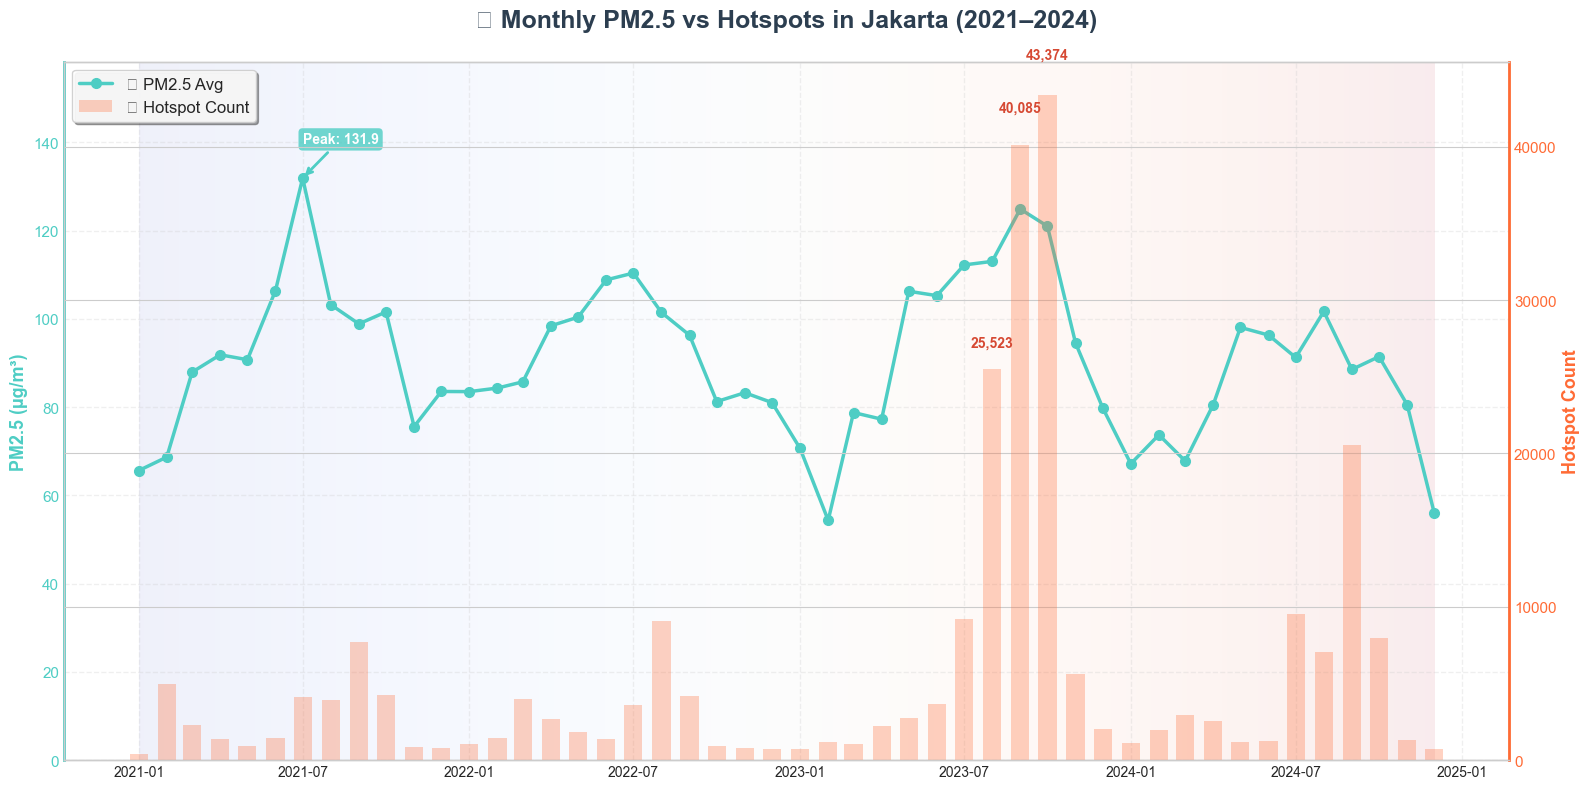

In [9]:
# --- Beautiful Monthly Comparison: Hotspots vs PM2.5 ---

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# --- Monthly Aggregation ---
hotspot_monthly = all_data.groupby(["year","month"])["latitude"].count().reset_index(name="hotspot_count")
pm25_monthly = df.groupby(["year","month"])["pm25"].mean().reset_index(name="pm25_avg")

monthly_data = pd.merge(hotspot_monthly, pm25_monthly, on=["year","month"])
monthly_data["date"] = pd.to_datetime(
    monthly_data["year"].astype(str) + "-" + monthly_data["month"].astype(str) + "-01"
)

# --- Dual-axis line plot with improved design ---
fig, ax1 = plt.subplots(figsize=(16,8))

# Background gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)
extent = [monthly_data["date"].min(), monthly_data["date"].max(), 0, monthly_data["pm25_avg"].max()*1.2]
ax1.imshow(gradient, aspect="auto", extent=extent, alpha=0.08, cmap="coolwarm")

# 🔹 PM2.5 line
line = ax1.plot(
    monthly_data["date"], monthly_data["pm25_avg"],
    color="#4ECDC4", marker="o", linewidth=2.5, markersize=7,
    label="💨 PM2.5 Avg"
)

# Highlight peaks
for x, y in zip(monthly_data["date"], monthly_data["pm25_avg"]):
    if y == monthly_data["pm25_avg"].max():
        ax1.annotate(f"Peak: {y:.1f}", xy=(x, y), xytext=(0, 25),
                     textcoords="offset points",
                     fontsize=10, fontweight="bold",
                     arrowprops=dict(arrowstyle="->", color="#4ECDC4", lw=2),
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="#4ECDC4", alpha=0.8, edgecolor="none"),
                     color="white")

ax1.set_ylabel("PM2.5 (µg/m³)", color="#4ECDC4", fontsize=13, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="#4ECDC4", labelsize=11)
ax1.spines["left"].set_color("#4ECDC4")
ax1.spines["left"].set_linewidth(2)

# 🔸 Hotspot bars
ax2 = ax1.twinx()
bars = ax2.bar(
    monthly_data["date"], monthly_data["hotspot_count"],
    width=20, alpha=0.3, color="#FF6B35",
    label="🔥 Hotspot Count"
)

ax2.set_ylabel("Hotspot Count", color="#FF6B35", fontsize=13, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="#FF6B35", labelsize=11)
ax2.spines["right"].set_color("#FF6B35")
ax2.spines["right"].set_linewidth(2)

# 🔹 Labels on major bars (only top 3)
top_hotspots = monthly_data.nlargest(3, "hotspot_count")
for _, row in top_hotspots.iterrows():
    ax2.text(row["date"], row["hotspot_count"] + row["hotspot_count"]*0.05,
             f'{int(row["hotspot_count"]):,}', ha="center", va="bottom",
             fontsize=10, fontweight="bold", color="#D64933")

# Title and grid
ax1.set_title("📅 Monthly PM2.5 vs Hotspots in Jakarta (2021–2024)",
              fontsize=18, fontweight="bold", pad=25, color="#2C3E50")
ax1.grid(True, alpha=0.3, linestyle="--", linewidth=1)

# Legend fix
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc="upper left", frameon=True, fancybox=True, shadow=True, fontsize=12
)

frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_alpha(0.9)

fig.tight_layout()
plt.show()


In [10]:
# # import folium

# # # Start map centered roughly on Indonesia
# # m = folium.Map(location=[-2, 118], zoom_start=5)

# # # Add hotspots as circle markers
# # for _, row in all_data.iterrows():
# #     folium.CircleMarker(
# #         location=[row["latitude"], row["longitude"]],
# #         radius=2,
# #         color="red" if row["frp"] > 10 else "blue",  # stronger fires = red
# #         fill=True,
# #         fill_opacity=0.6,
# #         popup=f"FRP: {row['frp']}, Brightness: {row['bright_ti4']}"
# #     ).add_to(m)

# # # Save map to file
# # m.save("hotspot_map.html")


# import folium
# import pandas as pd
# import branca.colormap as cm

# # Group by rounded lat/lon (reduce resolution)
# grid = (
#     all_data.groupby([
#         all_data["latitude"].round(1), 
#         all_data["longitude"].round(1)
#     ])
#     .size()
#     .reset_index(name="count")
# )

# # Create color scale based on count
# colormap = cm.linear.YlOrRd_09.scale(grid["count"].min(), grid["count"].max())

# m = folium.Map(location=[-2, 118], zoom_start=5)

# for _, row in grid.iterrows():
#     folium.CircleMarker(
#         location=[row["latitude"], row["longitude"]],
#         radius=min(row["count"]**0.5, 15),  
#         color=colormap(row["count"]),
#         fill=True,
#         fill_opacity=0.7,
#         popup=f"Hotspot Count: {row['count']}"
#     ).add_to(m)

# colormap.caption = "Hotspot Count"
# colormap.add_to(m)

# m.save("hotspot_count_colored.html")




In [11]:
# import folium
# import pandas as pd
# import branca.colormap as cm

# # Make sure we have datetime & year column
# all_data["acq_date"] = pd.to_datetime(all_data["acq_date"])
# all_data["year"] = all_data["acq_date"].dt.year

# # Aggregate by year and rounded lat/lon (to cluster nearby hotspots)
# grid = (
#     all_data.groupby([
#         "year",
#         all_data["latitude"].round(1),
#         all_data["longitude"].round(1)
#     ])
#     .size()
#     .reset_index(name="count")
# )

# # Loop through each year and create a separate map
# for y, subset in grid.groupby("year"):
#     m = folium.Map(location=[-2, 118], zoom_start=5)

#     # Color scale for this year's data
#     colormap = cm.linear.YlOrRd_09.scale(subset["count"].min(), subset["count"].max())

#     for _, row in subset.iterrows():
#         folium.CircleMarker(
#             location=[row["latitude"], row["longitude"]],
#             radius=min(row["count"]**0.5, 15),  
#             color=colormap(row["count"]),
#             fill=True,
#             fill_opacity=0.7,
#             popup=f"Year: {y}, Count: {row['count']}"
#         ).add_to(m)

#     colormap.caption = f"Hotspot Count ({y})"
#     colormap.add_to(m)

#     # Save map for each year
#     m.save(f"hotspot_count_{y}.html")
